In [1]:
%load_ext autoreload 
%autoreload 2

import os
import random
from collections import deque
import numpy as np
import scipy.linalg as sl
from PIL import Image
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display

import torch
from torch import nn, distributions as dist, autograd
from torch.func import jacfwd
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# torch.set_default_device("cuda")
torch.set_default_dtype(torch.float32)
plt.style.use('seaborn-v0_8')

from mnist import MNISTTrain, MNISTTest

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 28
batch_size = 128
num_classes = 10

In [3]:
train_ds = MNISTTrain(transform=Compose([
    ToTensor(),
    RandomHorizontalFlip(0.1),
    RandomVerticalFlip(0.1),
    Normalize(127., 128.0)
]))
val_ds = MNISTTest(transform=Compose([
    ToTensor(),
    Normalize(127., 128.0)
]))


In [4]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, drop_last=True)

In [5]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)


class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1, **kwargs):
        super().__init__()
        c_hid1 = hidden_features//2
        c_hid2 = hidden_features
        c_hid3 = hidden_features*2

        self.cnn_layers = nn.Sequential(
                nn.Conv2d(1, c_hid1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(c_hid1, c_hid2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(c_hid2, c_hid3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(c_hid3, c_hid3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(c_hid3*4, c_hid3),
                Swish(),
                nn.Linear(c_hid3, out_dim)
        )

    def forward(self, x):
        x = self.cnn_layers(x).squeeze(dim=-1)
        return x

In [6]:
ebm = CNNModel()
# ebm(torch.randn((2, 1, 28, 28)))
ebm.cuda()

CNNModel(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(4, 4))
    (1): Swish()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): Swish()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): Swish()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): Swish()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=256, out_features=64, bias=True)
    (10): Swish()
    (11): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [7]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,)+img_shape)*2-1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        inp_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(torch.device("cuda"))

        # Perform MCMC sampling
        inp_imgs = Sampler.generate_samples(self.model, inp_imgs, steps=steps, step_size=step_size)

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(inp_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return inp_imgs

    @staticmethod
    def generate_samples(model, inp_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            inp_imgs - Images to start from for sampling. If you want to generate new images, enter noise between -1 and 1.
            steps - Number of iterations in the MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        inp_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # We use a buffer tensor in which we generate noise each loop iteration.
        # More efficient than creating a new tensor every iteration.
        noise = torch.randn(inp_imgs.shape, device=inp_imgs.device)

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # Part 1: Add noise to the input.
            noise.normal_(0, 0.005)
            inp_imgs.data.add_(noise.data)
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            # Part 2: calculate gradients for the current input.
            out_imgs = -model(inp_imgs)
            out_imgs.sum().backward()
            inp_imgs.grad.data.clamp_(-0.03, 0.03) # For stabilizing and preventing too high gradients

            # Apply gradients to our current samples
            inp_imgs.data.add_(-step_size * inp_imgs.grad.data)
            inp_imgs.grad.detach_()
            inp_imgs.grad.zero_()
            inp_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(inp_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return inp_imgs

In [8]:
class Trainer:
    
    def __init__(self, model, train_loader, 
                 val_loader=None, epochs=0, 
                 savepath=None, K=1, batch_size=1,
                 grad_step_scale=1., 
                 eval_epoch=1000000, 
                 img_shape=(1,28,28)):
        self.cnn = model
        self.optimizer = torch.optim.Adam(self.cnn.parameters(), lr=1e-5)    

        self.epochs = epochs
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.batch_size = batch_size
        self.sampler = Sampler(self.cnn, 
                               img_shape=img_shape, sample_size=batch_size)
        
    def fit(self, epoch, loader):
        losses = []
        for step, (img, label) in enumerate(loader):
            real_imgs = img.cuda()
            
            # TODO comment for debug
            small_noise = torch.randn_like(real_imgs) * 0.005
            real_imgs.add_(small_noise).clamp_(min=-1.0, max=1.0)
            fake_imgs = self.sampler.sample_new_exmps(steps=60, step_size=10)
            self.cnn.train()
            # Obtain samples

            # Predict energy score for all images
            inp_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
            real_out, fake_out = self.cnn(inp_imgs).chunk(2, dim=0)

            # Calculate losses
            reg_loss = 0.1 * (real_out ** 2 + fake_out ** 2).mean()
            cdiv_loss = fake_out.mean() - real_out.mean()
            loss = reg_loss + cdiv_loss
            
            if torch.isnan(loss).item():
                continue
            
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.cnn.parameters(), 2.)
            self.optimizer.step()
            losses.append(loss.item())

            if step % 10 == 0:
                print(f"Epoch: {epoch}, step: {step}, loss: {np.mean(losses)}")
           
            if step == 200:
                break
        
        return losses

    def train(self):
        self.train_losses = []
        for epoch in range(1, self.epochs + 1):
            losses = self.fit(epoch, train_loader)
            self.train_losses.extend(losses)
        #     if epoch % self.eval_epoch == 0:
        #         self.evaluate(epoch)
        # self.generate_imgs(16)
        return self.train_losses
    
    def evaluate(self, epoch=None):
        if self.val_loader is None:
            return
        if epoch is None:
            epoch = 0
        savepath = os.path.join(self.savepath, "evaluation", f"{epoch}")
        os.makedirs(savepath, exist_ok=True)
        self.model.eval()
        re, fe = 0.0, 0.
        with torch.no_grad():
            k = 0
            for (img, label) in self.val_loader:
                real_img = img.cuda()
                fake_img = torch.rand(real_img.size(0), 1, img_size, img_size).cuda()
                
                real_energy = self.model(real_img)
                fake_energy = self.model(fake_img)
                
                re += real_energy.mean().item()
                fe += fake_energy.mean().item()
        print(f"Evaluation epoch {epoch} loss: {re - fe}, real_energy {re}, fake_energy {fe}")
        self.model.train()
    
    def generate_imgs(self, nsample):
        savepath = os.path.join(self.savepath, f"samples")
        os.makedirs(savepath, exist_ok=True)
        with torch.no_grad():
            xgen = self.sample_langevin(sample_size=nsample, return_img_gen=True, steps=256)

            imgs = xgen.permute((0, 1, 3, 4, 2))
            imgs = imgs.squeeze(-1)
            
            imgs *= 128.
            imgs += 127.
            
            imgs = imgs.unbind()
            for n in range(nsample):
                # img_path = os.path.join(savepath, f"{n:03d}")
                # os.makedirs(img_path, exist_ok=True)
                fname = os.path.join(savepath, f"img{n}.jpeg")
                self.save_img(imgs[n], fname)
    
    def save_img(self, imgs, fname, timesteps=16):
        length = imgs.shape[0]
        npic = length // timesteps 
        
        nrow = int(np.sqrt(npic))
        ncol = int(np.sqrt(npic))
        fig, axes = plt.subplots(nrows=nrow, ncols=ncol)
        for i in range(nrow):
            for j in range(ncol):
                axes[i, j].imshow(imgs[nrow * npic + npic * ncol])
                # axes[i, j].set_xaxis_off()
        fig.savefig(fname)
        plt.close()

In [9]:
mnist_trainer = Trainer(ebm, 
                        train_loader=train_loader, 
                        val_loader=val_loader,
                        epochs=50, 
                        savepath="/mnt/dl/generation/ebm/generation",
                        batch_size=batch_size,
                        # grad_step_scale=10.,
                        K=50,
                        eval_epoch=10,
                        )

In [10]:
mnist_trainer.train()

Epoch: 1, step: 0, loss: 0.0001292488886974752
Epoch: 1, step: 10, loss: 0.00020195250611074945
Epoch: 1, step: 20, loss: 3.2813809368582e-05
Epoch: 1, step: 30, loss: -0.0001759304150548433
Epoch: 1, step: 40, loss: -0.000428081394979594
Epoch: 1, step: 50, loss: -0.00070470699004135
Epoch: 1, step: 60, loss: -0.0010124365236136878
Epoch: 1, step: 70, loss: -0.0013285907334648073
Epoch: 1, step: 80, loss: -0.0016593246520956817
Epoch: 1, step: 90, loss: -0.002022350258782383
Epoch: 1, step: 100, loss: -0.0024156400174280574
Epoch: 1, step: 110, loss: -0.002837564305901561
Epoch: 1, step: 120, loss: -0.0032999134965987554
Epoch: 1, step: 130, loss: -0.003799711201670544
Epoch: 1, step: 140, loss: -0.004352109497231398
Epoch: 1, step: 150, loss: -0.004960358763092031
Epoch: 1, step: 160, loss: -0.0056140150976806925
Epoch: 1, step: 170, loss: -0.006304464660032124
Epoch: 1, step: 180, loss: -0.0070486138114906356
Epoch: 1, step: 190, loss: -0.007861291660856534
Epoch: 1, step: 200, loss

[0.0001292488886974752,
 0.0002907325397245586,
 0.0001363924820907414,
 0.00020030647283419967,
 0.00014023605035617948,
 0.00021829345496371388,
 0.00016669597243890166,
 0.00039306876715272665,
 0.00020383292576298118,
 0.0001607618178240955,
 0.0001819081953726709,
 1.9149098079651594e-05,
 2.4871842470020056e-05,
 2.1371175535023212e-05,
 6.172480061650276e-05,
 -4.5621825847774744e-05,
 -0.00023650936782360077,
 -0.00022565218387171626,
 -0.00035081093665212393,
 -0.0003401594585739076,
 -0.0004607507144100964,
 -0.00023905921261757612,
 -0.0004413889837451279,
 -0.0004978015786036849,
 -0.00042434781789779663,
 -0.0006309150485321879,
 -0.0006479937583208084,
 -0.0007561392267234623,
 -0.0007727608899585903,
 -0.0008330378914251924,
 -0.0008994884556159377,
 -0.0009235524339601398,
 -0.000986519968137145,
 -0.000979479867964983,
 -0.001038221176713705,
 -0.0012471473310142756,
 -0.0011170250363647938,
 -0.001299145631492138,
 -0.0014932902995496988,
 -0.0014595044776797295,
 -0.

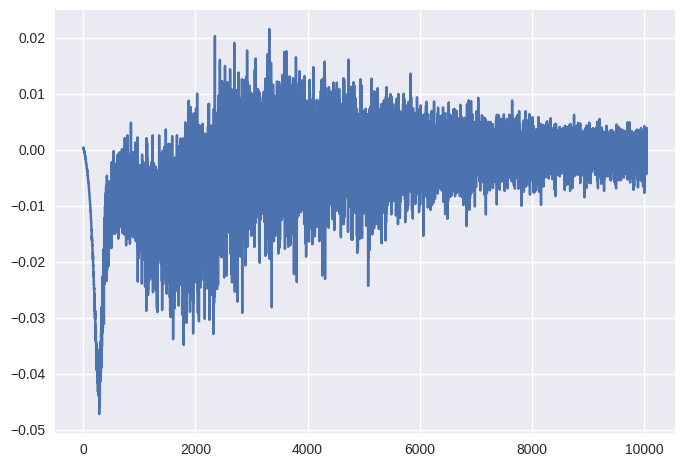

In [11]:
plt.plot(mnist_trainer.train_losses)